In [23]:
#puts above directory into the path
import sys
sys.path.append("../../VREP_robot")
sys.path.append("../../VREP_robot/utils")
sys.path.append("../")
import vrep
from vrepRobot import *

from forwardKinematics import robot_config
import numpy as np
import time

pi = np.pi

In [24]:
# myRobot = robot_config()
# vrep_env = VREP_Environement()
# robot_handles  = ['pose_j0', 'pose_j1', 'pose_j2', 'pose_j3', 'pose_j4', 'pose_j5', 'pose_j6', 'pose_j7']
# vrep_env.add_robot(VREP_Robot('robot', robot_handles))
# vrep_env.start_simulation()

In [25]:
# setup environment
myRobot = robot_config()
# vrep_env = VREP_Environement(synchronous=False)
vrep_env = VREP_Environement(synchronous=True)
ik_handles = ['ik_joint1', 'ik_joint2', 'ik_joint3', 'ik_joint4', 'ik_joint5', 'ik_joint6', 'ik_joint7', 'ik_ee', 'kinematicsTest_IKTip', 'ik_rf7_static']
vrep_env.add_robot(VREP_Robot('ik_robot', ik_handles, connection_type = 'nonblocking'))
vrep_env.start_simulation()

Connected to remote API server
In synchronous mode
1 robot(s) connected: ['ik_robot']


In [26]:
# start = time.time()

# while time.time() - start < 18:
#     dt = time.time() - start
#     a = np.sin(dt)*0.5
#     q = np.array([0.2, -2.5, 0., 0., 0., 0., 0. + a])
#     positions = np.zeros((8,3))
#     positions[1:,:] = (myRobot.forwardKinPos(q))
#     orientations = np.zeros((8, 4)) #4 for quat
#     orientations[0,-1] = 1

#     print('Forward kinematic positions: {}'.format(positions))
#     orientations[1:,:] = myRobot.forwardKinOrientation(q)
#     print('Forward kinematic orientations: {}'.format(orientations))

#     print(vrep_env.robot.handle_names)
#     for i in range(len(robot_handles)):
#         vrep_env.robot.setObjectPosition(vrep_env.robot.handles[i], positions[i])
#         vrep_env.robot.setObjectQuaternion(vrep_env.robot.handles[i], orientations[i])
        
#     time.sleep(0.2)

In [27]:
#JEE = myRobot.J('EE', q)
#print("analytic jacobian: \n{}".format(JEE))

In [101]:
vrep_env.ik_robot.getCollisionHandle('Collision')
time.sleep(1)

In [103]:
# initialize collision check
# !!!important
vrep_env.ik_robot.getCollisionState(initialize=True)
vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static',initialize=True)
vrep_env.ik_robot.getObjectOrientation(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static',initialize=True)
vrep_env.ik_robot.getObjectQuaternion(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static',initialize=True)

(0,
 [-0.8101062774658203,
  0.1923750638961792,
  0.3916119933128357,
  0.3916116952896118])

In [104]:
# generate config samples
from configGenerator_VREP import configGenerator_VREP
config = configGenerator_VREP.generate_sample(7)  # !!!set sample number here
total_config = config.shape[0]
print("total configs = ", total_config)
print(config)
print(total_config/50/3600)

total configs =  117649
[[-5.00000000e-02 -2.25000000e-02 -4.50000000e+01 -2.60000000e+01
  -2.51000000e+01 -2.60000000e+01]
 [-5.00000000e-02 -2.25000000e-02 -4.50000000e+01 -2.60000000e+01
  -2.51000000e+01 -1.73333333e+01]
 [-5.00000000e-02 -2.25000000e-02 -4.50000000e+01 -2.60000000e+01
  -2.51000000e+01 -8.66666667e+00]
 ...
 [ 5.00000000e-02  4.52500000e-01  4.50000000e+01  2.60000000e+01
   2.59000000e+01  8.66666667e+00]
 [ 5.00000000e-02  4.52500000e-01  4.50000000e+01  2.60000000e+01
   2.59000000e+01  1.73333333e+01]
 [ 5.00000000e-02  4.52500000e-01  4.50000000e+01  2.60000000e+01
   2.59000000e+01  2.60000000e+01]]
0.6536055555555556


In [105]:
# initialize collision state placeholder
y = np.zeros((total_config))
EEPosition = np.zeros((total_config,3))
EEOrientation = np.zeros((total_config,3))
EEQuaternion = np.zeros((total_config,4))

In [106]:
# collision detect
from tqdm import tqdm_notebook as tqdm

pbar = tqdm(total=total_config)  # set progress bar

t = time.clock()
for i in range(total_config):
#for i in range(len(jointAngle)):
    joint_angle = config[i, :]
    for j in range(6):
        vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[j], joint_angle[j])
    #vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[5], jointAngle[i])
    
    vrep.simxSynchronousTrigger(vrep_env.clientID)
    #vrep.simxGetPingTime(vrep_env.clientID)
    #time.sleep(1)
    collisionState = vrep_env.ik_robot.getCollisionState()
    #print(collisionState)
    y[i] = collisionState
    vrep.simxSynchronousTrigger(vrep_env.clientID)
    #vrep.simxGetPingTime(vrep_env.clientID)
    EEPosition[i,:] = vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    EEOrientation[i,:] = vrep_env.ik_robot.getObjectOrientation(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    EEQuaternion[i,:] = vrep_env.ik_robot.getObjectQuaternion(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    pbar.update(1)
#     time.sleep(0.5)
    #print(EEPosition[i,:])
    
    if i%int(total_config/100+1) == 0:
        Data = np.hstack((config, y.reshape(-1,1),EEPosition,EEOrientation,EEQuaternion))
        #np.save(r'C:\Users\xumw1\Documents\GitHub\robotPathPlanning\logs\CollisionData{}.npy'.format(i),Data)
        np.save('logs/CollisionData{}.npy'.format(i),Data)
    
pbar.close()
print('runtime = ', time.clock()-t)  
print('collision state = ', y)
print('EEPosition\n', EEPosition)
print('EEPrientation\n', EEOrientation)
print('EEQuaternion\n', EEQuaternion)
#np.save(r'C:\Users\xumw1\Documents\GitHub\robotPathPlanning\logs\CollisionData.npy',Data)
np.save('logs/CollisionData.npy',Data)


runtime =  3076.296190814815
collision state =  [1. 1. 1. ... 1. 1. 1.]
EEPosition
 [[-0.10452056  0.29297423 -0.36421895]
 [-0.10452056  0.29297423 -0.36421895]
 [-0.10452056  0.29297423 -0.36421895]
 ...
 [-0.14231169  0.18536898  0.14236009]
 [-0.14231169  0.18536898  0.14236009]
 [-0.14231169  0.18536898  0.14236009]]
EEPrientation
 [[-2.01463223 -0.4926959  -2.32834673]
 [-2.01463223 -0.4926959  -2.32834673]
 [-2.01463223 -0.4926959  -2.32834673]
 ...
 [-2.0282886  -0.50501668  0.78470683]
 [-2.0282886  -0.50501668  0.78470683]
 [-2.0282886  -0.50501668  0.78470683]]
EEQuaternion
 [[-0.20463538 -0.80454409 -0.3942292   0.39422908]
 [-0.20463538 -0.80454409 -0.3942292   0.39422908]
 [-0.20463538 -0.80454409 -0.3942292   0.39422908]
 ...
 [-0.81010628  0.19237506  0.39161199  0.3916117 ]
 [-0.81010628  0.19237506  0.39161199  0.3916117 ]
 [-0.81010628  0.19237506  0.39161199  0.3916117 ]]


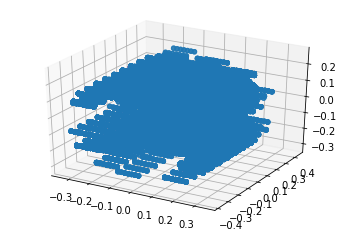

In [107]:
# plot
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-EEPosition[:,1], EEPosition[:,2], -EEPosition[:,0])
plt.show()

In [108]:
EEPosition_free = EEPosition[y==0,:]
print(EEPosition_free)

[[-0.13358343  0.13937679 -0.12829268]
 [-0.13358343  0.13937679 -0.12829268]
 [-0.10452056  0.29297423 -0.36421895]
 ...
 [-0.11258399 -0.00574359  0.34897619]
 [-0.11258399 -0.00574359  0.34897619]
 [-0.18119943  0.11746475  0.27897912]]


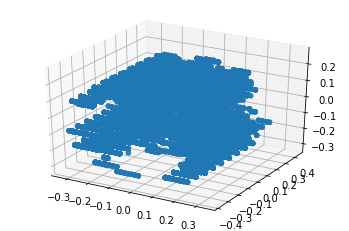

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-EEPosition_free[:,1], EEPosition_free[:,2], -EEPosition_free[:,0])
plt.show()

In [93]:
#test
EEPosition = np.zeros((5,3))
joint_angle = np.linspace(0,1,5)
for i in range(5):
    vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[0], joint_angle[i])
    vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[1], joint_angle[i])
    vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[3], joint_angle[i])
    vrep.simxSynchronousTrigger(vrep_env.clientID)
    vrep.simxGetPingTime(vrep_env.clientID)
    collisionState = vrep_env.ik_robot.getCollisionState()
    EEPosition[i,:] = vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    time.sleep(1)
    print(collisionState)
print('EEPosition\n', EEPosition)

False
True
True
True
True
EEPosition
 [[-0.14231169  0.12143329 -0.13218689]
 [-0.14231157 -0.03155687  0.08037645]
 [-0.14231145  0.00473002  0.28247321]
 [-0.14231133  0.02803704  0.47708142]
 [-0.14231157  0.03536907  0.68985993]]


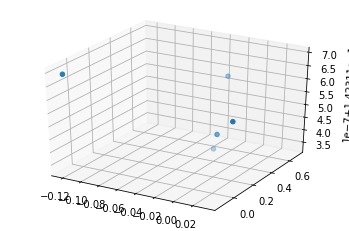

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-EEPosition[:,1], EEPosition[:,2], -EEPosition[:,0])
plt.show()